(480, 32, 32, 1) (120, 32, 32, 1)
(120, 2) (480, 2)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.

Epoch 1: LearningRateScheduler setting learning rate to 0.000125.
Epoch 1/23
15/15 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4958
Epoch 1: val_accuracy improved from -inf to 0.42500, saving model to weights.best.hdf5
15/15 [==============================] - 4s 138ms/step - loss: 0.6935 - accuracy: 0.4958 - val_loss: 0.6945 - val_accuracy: 0.4250 - lr: 1.2500e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00025.
Epoch 2/23
15/15 [==============================] - ETA: 0s - loss: 0.6863 - accuracy: 0.5562
Epoch 2: val_accuracy improved from 0.42500 to 0.45000, saving model to weights.best.hdf5
15/15 [==============================] - 2s 137ms/step - loss: 0.6863 - accuracy: 0.5562 - val_loss: 0.6849 - val_accuracy: 0.4500 - lr: 2.5000e-04

Epoc

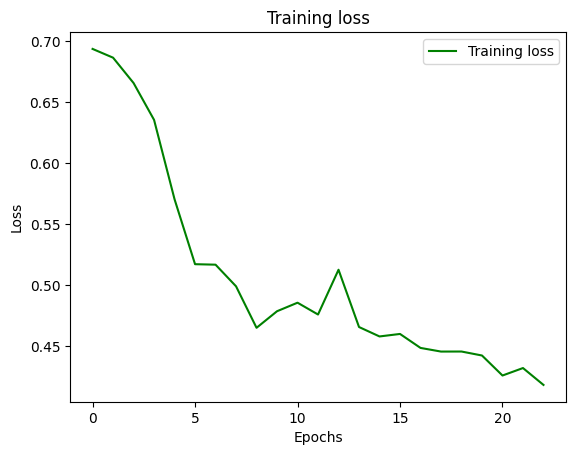

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.applications import ResNet152V2
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from pandas import read_csv
import numpy as np
import os
import time
from cv2 import imread, IMREAD_GRAYSCALE # IMREAD_GRAYSCALE allow you to load the image as gray scale image

# import some tensorflow packages to help you build the model
# import some tensorflow packages to help you build the model

# import other packages here
# GRADED CODE: Advanced implementation
### Data preprocess & augmentation ###

PATH = "Training_data"  #path to your training image
file_dir = os.listdir(PATH) #read the images from the directory
file_dir.sort() #Make sure the images are loaded in order
X_train = np.array([])
for i in range(len(file_dir)):
    if (i != 0):
        img_gray = imread(PATH+"/"+file_dir[i], IMREAD_GRAYSCALE)
        img_gray = img_gray.reshape(1, img_gray.shape[0], img_gray.shape[1], 1)
        X_train = np.concatenate([X_train, img_gray], axis=0)
    else:
        img_gray = imread(PATH+"/"+file_dir[0], IMREAD_GRAYSCALE)
        img_gray = img_gray.reshape(1, img_gray.shape[0], img_gray.shape[1], 1)
        X_train = img_gray
X_train = np.divide(X_train, 255)

PATH = "Testing_data"  #path to your testing image
file_dir = os.listdir(PATH)
file_dir.sort()
X_test = np.array([])

for i in range(0, len(file_dir)):
    if (i != 0):
        img_gray = imread(PATH+"/"+file_dir[i], IMREAD_GRAYSCALE)
        img_gray = img_gray.reshape(1, img_gray.shape[0], img_gray.shape[1], 1)
        X_test = np.concatenate([X_test, img_gray], axis=0)
    else:
        img_gray = imread(PATH+"/"+file_dir[0], IMREAD_GRAYSCALE)
        img_gray = img_gray.reshape(1, img_gray.shape[0], img_gray.shape[1], 1)
        X_test = img_gray

X_test = np.divide(X_test, 255)

data = read_csv("Training_label.csv")

y_train = []
data = data.values
y_train = data[:, 1].reshape(data[:, 1].shape[0], 1)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

print(X_train.shape, X_val.shape)

# datagen = ImageDataGenerator(
#       rotation_range=35,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=False,
#       fill_mode='nearest')


# datagen.fit(X_train)

# X_train_aug, y_train_aug = [], []

# i = 0
# for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=3):
#     i += 1
#     if i > 480:
#         break 
#     if (len(X_train_aug) != 0):
#         X_train_aug = np.concatenate([X_train_aug, X_batch], axis=0)
#         y_train_aug = np.concatenate([y_train_aug, y_batch], axis=0)

#     else:
#         X_train_aug = X_batch
#         y_train_aug = y_batch

# print(X_train_aug.shape, y_train_aug.shape)

# X_train = np.concatenate([X_train, X_train_aug], axis=0)
# y_train = np.concatenate([y_train, y_train_aug], axis=0)

X_train = tf.convert_to_tensor(X_train)
y_train=np.asarray(y_train).astype(int)
y_train = tf.convert_to_tensor(y_train)
y_train = tf.keras.utils.to_categorical(y_train, 2)

X_val = tf.convert_to_tensor(X_val)
y_val=np.asarray(y_val).astype(int)
y_val = tf.convert_to_tensor(y_val)
y_val = tf.keras.utils.to_categorical(y_val, 2)

print(y_val.shape, y_train.shape)


# GRADED CODE: Advanced implementation
CNN = tf.keras.Sequential(name='CNN')
CNN.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,1)))
CNN.add(layers.MaxPool2D((2,2)))
CNN.add(layers.Conv2D(64,(3,3),activation='relu'))
CNN.add(layers.MaxPool2D((2,2)))
CNN.add(layers.Conv2D(64,(3,3),activation='relu'))
CNN.add(layers.Flatten())

CNN.add(layers.Dropout(0.5))
CNN.add(layers.Dense(2048,activation='relu'))
CNN.add(layers.Dropout(0.4))
CNN.add(layers.Dense(512,activation='relu'))
CNN.add(layers.Dense(128,activation='relu'))
CNN.add(layers.Dense(64,activation='relu'))
CNN.add(layers.Dense(2,activation='softmax'))

tf.keras.utils.plot_model(CNN, show_shapes=True)
### Start training ###

LR = 0.0008
WARMUP_EPOCH = 4
epochs_num = 23

def scheduler(epoch, lr):
  if epoch < WARMUP_EPOCH:
    warmup_percent = (epoch+1) / WARMUP_EPOCH
    return LR * warmup_percent
  else:
    return lr**1.0008

from tensorflow.python import metrics

CNN.compile(optimizer=tf.keras.optimizers.Adam(LR),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
      metrics=['accuracy'])

callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')

time_start = time.time()
# CNN.fit(X_train, y_train, epochs=20)
history = CNN.fit(
      X_train, y_train,
      epochs=epochs_num,
      callbacks=[callback, checkpoint],
      validation_data = (X_val, y_val),
      verbose=True)

# score = CNN.evaluate(X_val, y_val, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
time_end = time.time()
time_c= time_end - time_start   #執行所花時間
print('time cost', time_c, 's')

plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# import other packages here